# Data description

The dataset we are using for analysis:
* Segmenting and Clustering Neighborhoods in New York City :https://codekarim.com/node/57
* NYPD Arrest Data: https://www.kaggle.com/datasets/thaddeussegura/nypd-arrest-data-20062019
* NYC Airbnb Data: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
* NYC property Sales: https://www.kaggle.com/datasets/johnshuford/new-york-city-property-sales
* NYC motor vehicle collision: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

## Data preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager as fm
from  matplotlib import cm
import json
import requests
from pandas.io.json import json_normalize
from geopy.distance import geodesic

In [2]:
crimeData = pd.read_csv("data/NYPD_Arrests_Data__Historic_.csv").dropna()
collisionData = pd.read_csv("data/Motor_Vehicle_Collisions_-_Crashes.csv")
airbnbData = pd.read_csv("data/AB_NYC_2019.csv").dropna()

C:\Users\amper\AppData\Local\Temp/ipykernel_4848/564835888.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisionData = pd.read_csv("data/Motor_Vehicle_Collisions_-_Crashes.csv")


### variables in the crime data

In [3]:
print (crimeData.dtypes)

ARREST_KEY             int64
ARREST_DATE           object
PD_CD                float64
PD_DESC               object
KY_CD                float64
OFNS_DESC             object
LAW_CODE              object
LAW_CAT_CD            object
ARREST_BORO           object
ARREST_PRECINCT      float64
JURISDICTION_CODE    float64
AGE_GROUP             object
PERP_SEX              object
PERP_RACE             object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lon_Lat               object
dtype: object


### variables in the collision data

In [4]:
print (collisionData.dtypes)

CRASH DATE                        object
CRASH TIME                        object
BOROUGH                           object
ZIP CODE                          object
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                          object
ON STREET NAME                    object
CROSS STREET NAME                 object
OFF STREET NAME                   object
NUMBER OF PERSONS INJURED        float64
NUMBER OF PERSONS KILLED         float64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
COLLISION_ID                       int64
VEHICLE TYPE COD

### variables in the airbnb data

In [5]:
print (airbnbData.dtypes)

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


## Show crime distribution from NYPD in pie chart

In [6]:
def plotPieChart(data,label,title):
    fig, axes = plt.subplots(figsize=(15,15),ncols=2)
    ax1, ax2 = axes.ravel()

    colors = cm.rainbow(np.arange(len(data))/len(data))# colormaps: Paired, autumn, rainbow, gray,spring,Darks
    patches, texts, autotexts = ax1.pie(data, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=170, colors=colors)

    ax1.axis('equal')  
    
    proptease = fm.FontProperties()
    proptease.set_size('xx-small')
    # font size include: ‘xx-small’,x-small’,'small’,'medium’,‘large’,‘x-large’,‘xx-large’ or number, e.g. '12'
    plt.setp(autotexts, fontproperties=proptease)
    plt.setp(texts, fontproperties=proptease)

    ax1.set_title(title, loc='center')
    ax2.axis('off')
    ax2.legend(patches, labels, loc='center left')

    plt.tight_layout()
    plt.savefig('Demo_project_set_legend_good.jpg')
    plt.show()

In [7]:
crimeData.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
3,189714430,11/07/2018,117.0,RECKLESS ENDANGERMENT 1,126.0,MISCELLANEOUS PENAL LAW,PL 1202500,F,M,26.0,0.0,45-64,M,WHITE,993685.0,233346.0,40.807160,-73.965920,POINT (-73.96591978699998 40.80715993100006)
5,190017529,11/15/2018,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,B,47.0,0.0,45-64,M,BLACK,1026486.0,262591.0,40.887333,-73.847250,POINT (-73.84725001299995 40.88733281800006)
10,189678705,11/07/2018,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,M,B,52.0,0.0,25-44,M,BLACK,1017542.0,255919.0,40.869059,-73.879630,POINT (-73.87963014799993 40.86905853200005)
14,189068425,10/22/2018,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,K,94.0,0.0,45-64,M,BLACK,995886.0,200705.0,40.717566,-73.958026,POINT (-73.95802570099994 40.71756616100004)
15,65864442,09/17/2009,164.0,SODOMY 3,116.0,SEX CRIMES,PL 1304002,F,S,122.0,0.0,25-44,M,BLACK HISPANIC,954943.0,148360.0,40.573850,-74.105496,POINT (-74.10549615599997 40.573849649000074)


Let's take a look a the distrubation of crime type and where they happend

In [8]:
typeCount = crimeData['OFNS_DESC']
typeCount = typeCount.value_counts(sort=True)
labels =typeCount.index
number = np.array(typeCount)

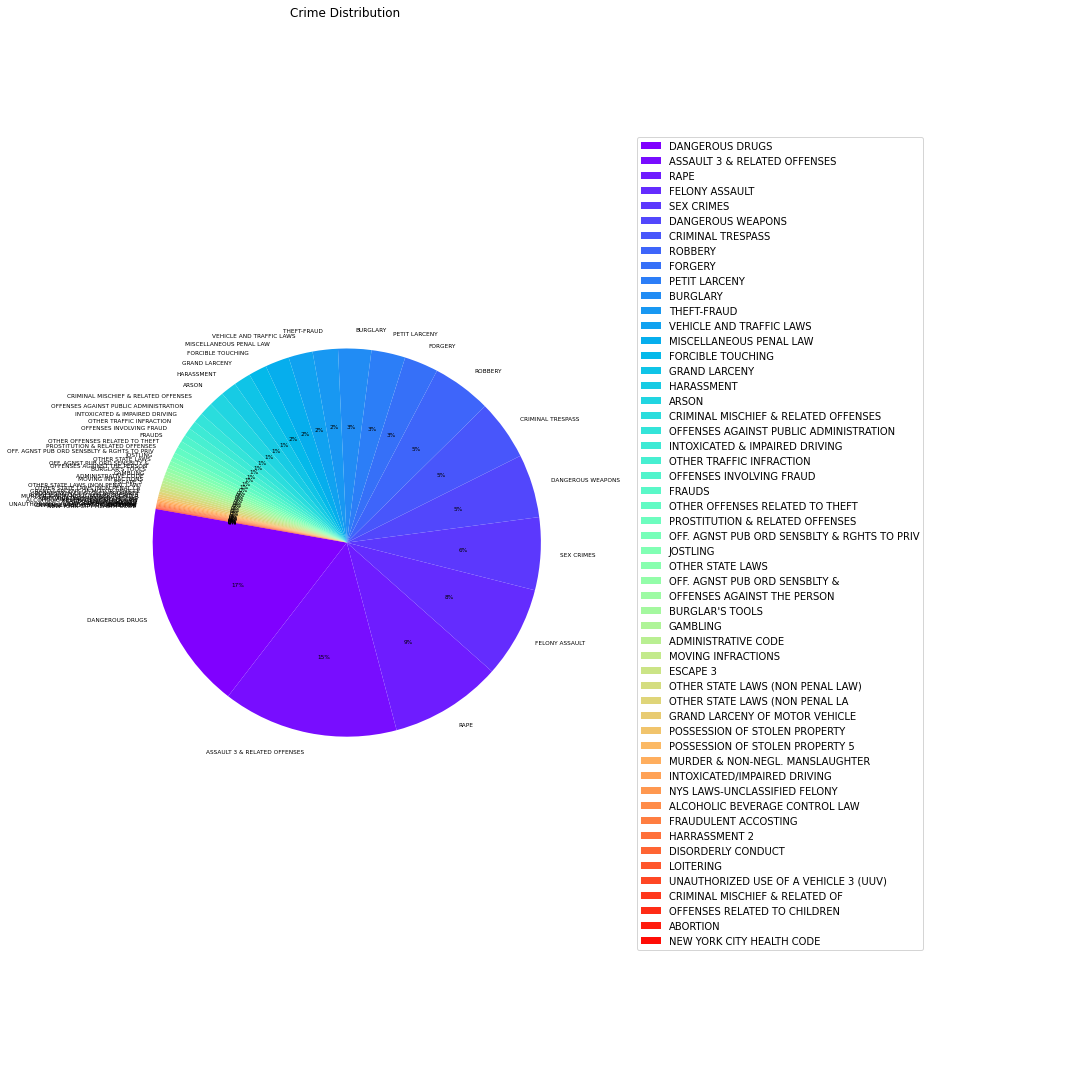

In [9]:
plotPieChart(number,labels, "Crime Distribution")

Then, let's take a look a how these arrests distribute amoung boroughs.

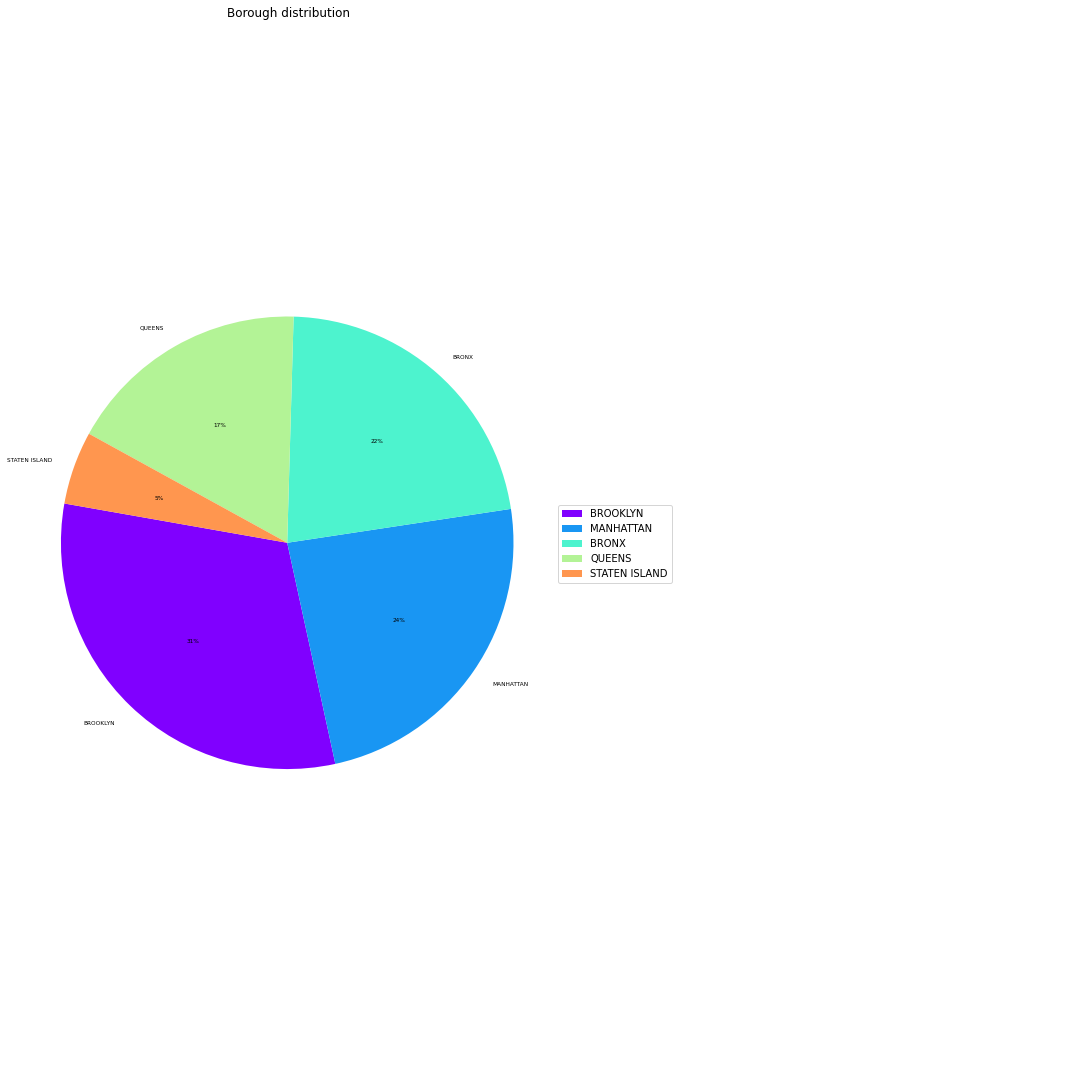

In [10]:
typeBorough = crimeData['ARREST_BORO']
typeBorough = typeBorough.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
typeCountB = typeBorough.value_counts()
labels = typeCountB.index
numberB = np.array(typeCountB)
plotPieChart(typeCountB,labels,"Borough distribution")

Based on previous pie chart, we select severl crime that happens alot and might affect house rent and sale prices.
There Assault, theft, and trespassing. We check these types of crime separatly in different borough.

In [11]:
crimeGivenBorough = crimeData[['OFNS_DESC','ARREST_BORO']]

In [12]:
assult = crimeGivenBorough.loc[crimeGivenBorough['OFNS_DESC']=='ASSAULT 3 & RELATED OFFENSES']
theft = crimeGivenBorough.loc[crimeGivenBorough['OFNS_DESC']=='OTHER OFFENSES RELATED TO THEFT']
threspassing = crimeGivenBorough.loc[crimeGivenBorough['OFNS_DESC']=='CRIMINAL TRESPASS']

Lets plot them out

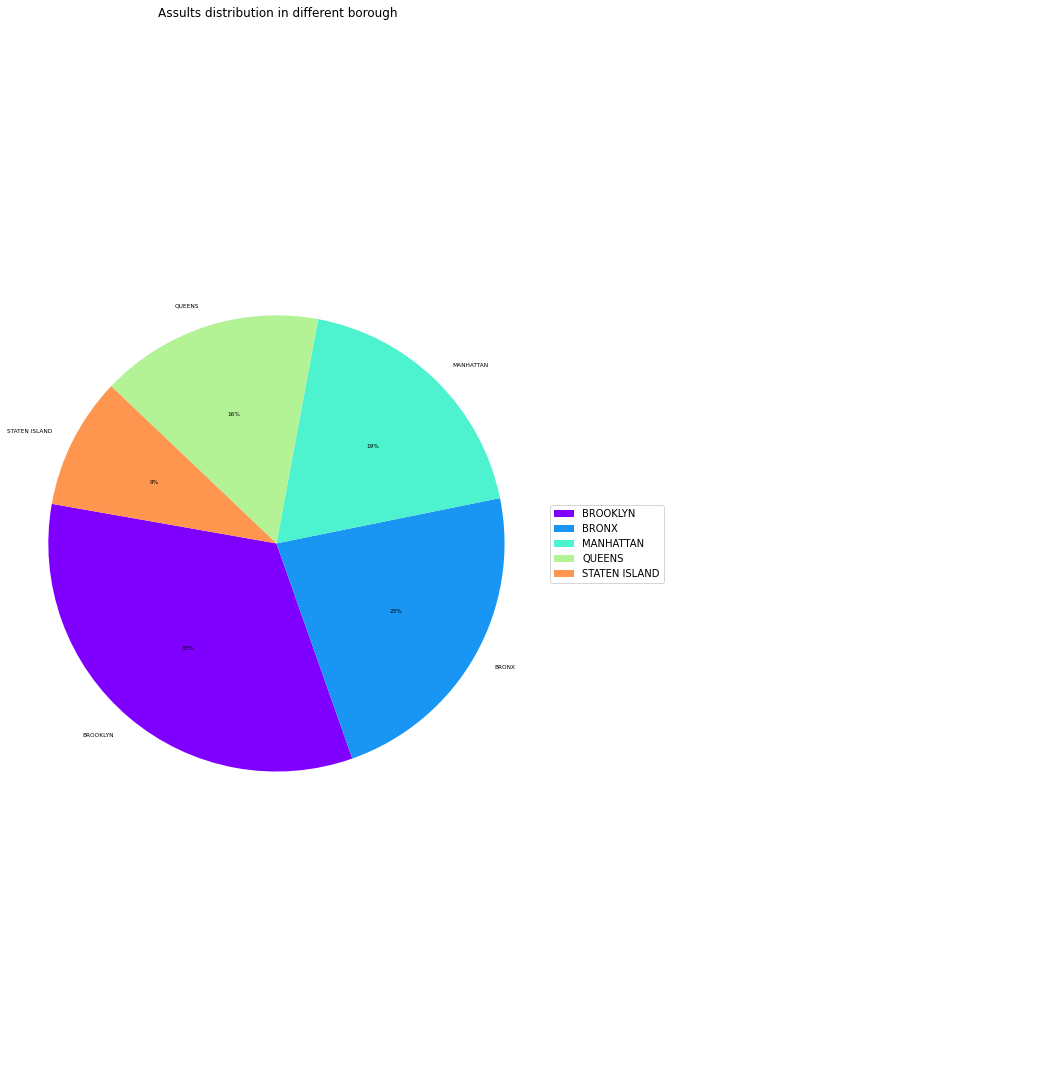

In [13]:
data = assult['ARREST_BORO']
data = data.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
data = data.value_counts()
labels = data.index
plotPieChart(data,labels,"Assults distribution in different borough")

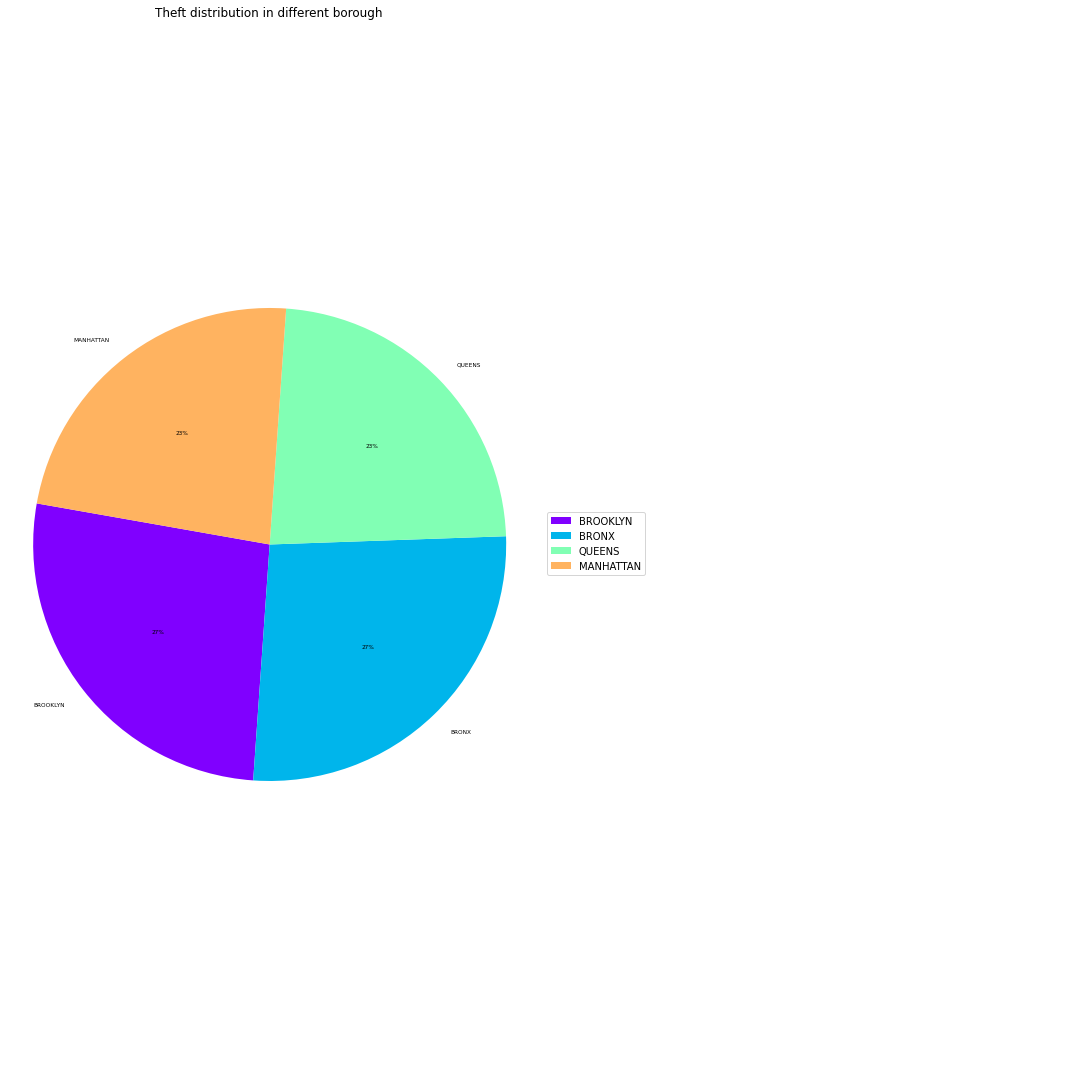

In [14]:
data = theft['ARREST_BORO']
data = data.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
data = data.value_counts()
labels = data.index
plotPieChart(data,labels,"Theft distribution in different borough")

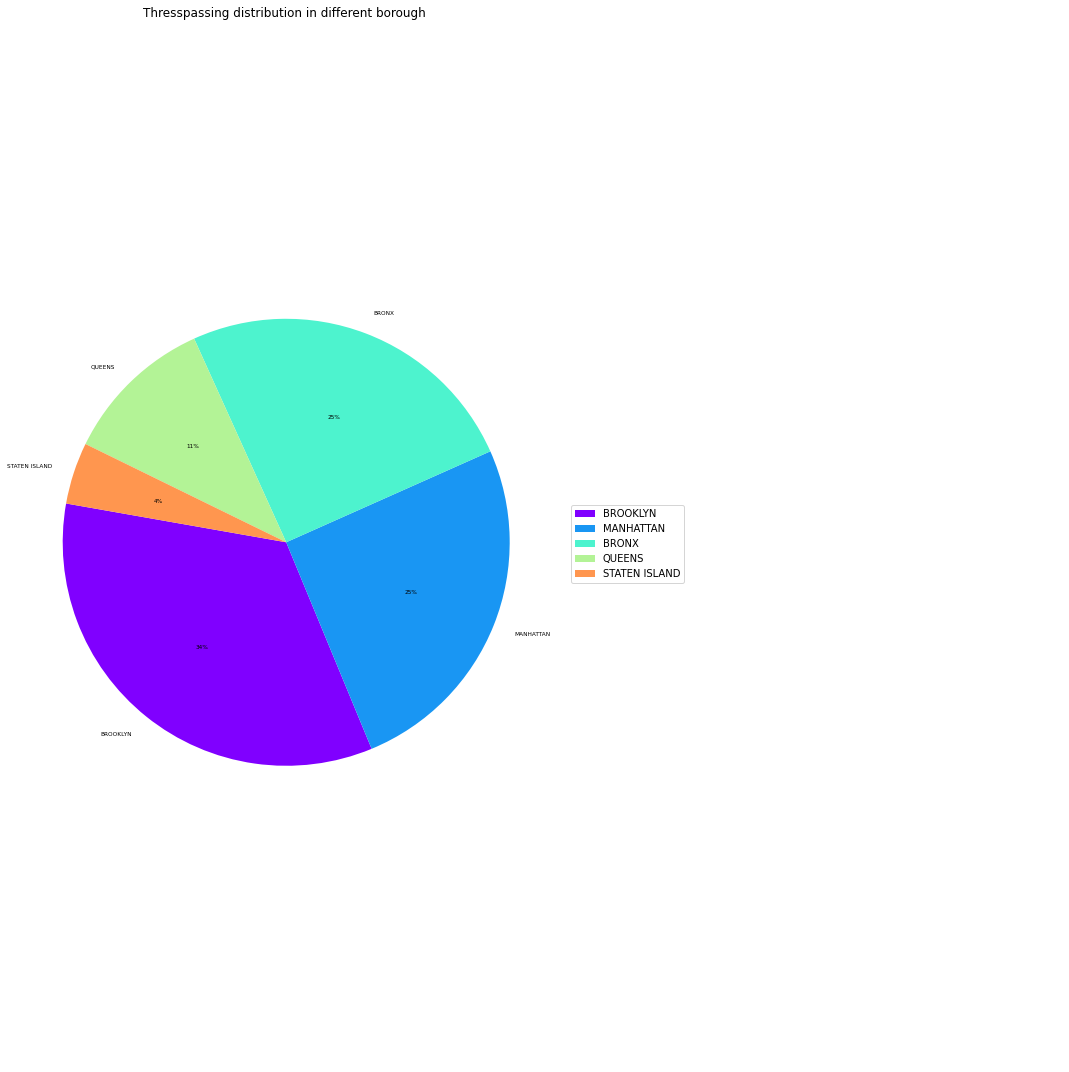

In [15]:
data = threspassing['ARREST_BORO']
data = data.replace(['K','Q','M','B','S'], ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'BRONX', 'STATEN ISLAND'])
data = data.value_counts()
labels = data.index
plotPieChart(data,labels,"Thresspassing distribution in different borough")

Lets now have a view of collision data and how these collision distributed among boroughs

In [16]:
collisionData.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/14/2021,5:32,NaN,NaN,NaN,NaN,NaN,BRONX WHITESTONE BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4407480,Sedan,Sedan,NaN,NaN,NaN
1,04/13/2021,21:35,BROOKLYN,11217.0,40.68358,-73.97617,"(40.68358, -73.97617)",NaN,NaN,620 ATLANTIC AVENUE,...,NaN,NaN,NaN,NaN,4407147,Sedan,NaN,NaN,NaN,NaN
2,04/15/2021,16:15,NaN,NaN,NaN,NaN,NaN,HUTCHINSON RIVER PARKWAY,NaN,NaN,...,NaN,NaN,NaN,NaN,4407665,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
3,04/13/2021,16:00,BROOKLYN,11222.0,NaN,NaN,NaN,VANDERVORT AVENUE,ANTHONY STREET,NaN,...,Unspecified,NaN,NaN,NaN,4407811,Sedan,NaN,NaN,NaN,NaN
4,04/12/2021,8:25,NaN,NaN,0.00000,0.00000,"(0.0, 0.0)",EDSON AVENUE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4406885,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


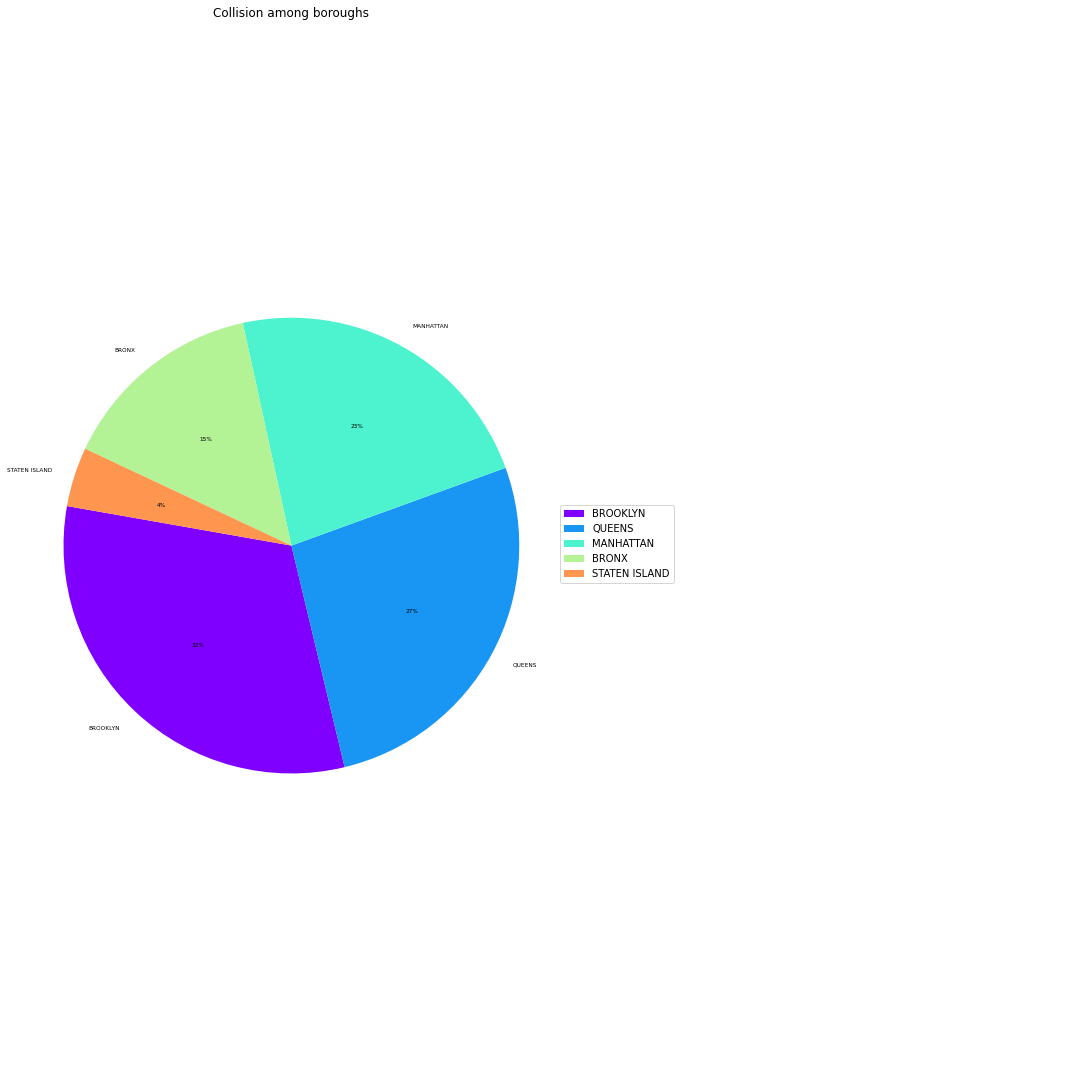

In [17]:
collisionBorough = collisionData['BOROUGH']
collisionBorough = collisionBorough.value_counts()
labels = collisionBorough.index
plotPieChart(collisionBorough,labels,"Collision among boroughs")

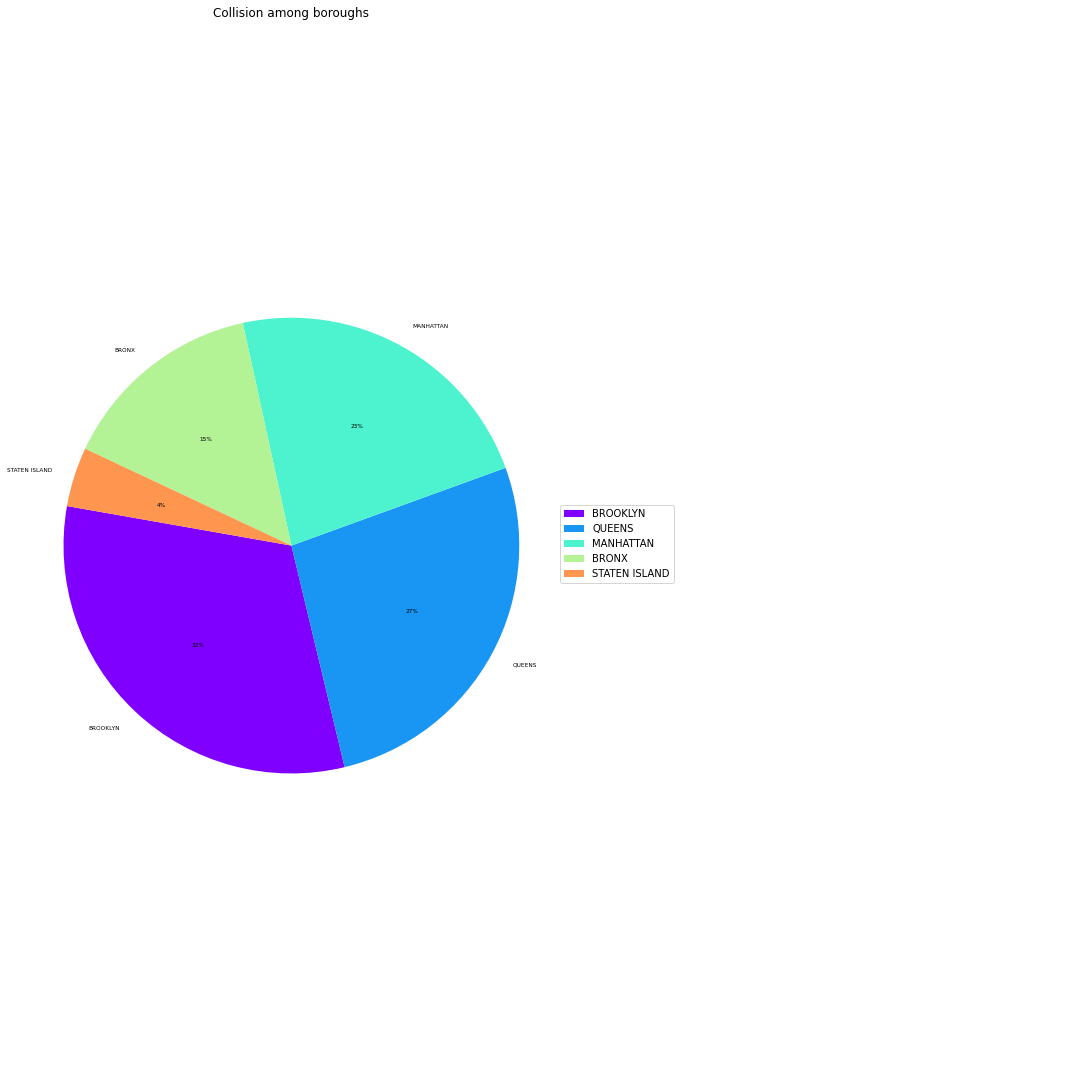

In [18]:
collisionBorough = collisionData['BOROUGH']
collisionBorough = collisionBorough.value_counts()
labels = collisionBorough.index
plotPieChart(collisionBorough,labels,"Collision among boroughs")

In [19]:
collisionVehicle = collisionData['VEHICLE TYPE CODE 1']
collisionVehicle = collisionVehicle.value_counts();
collisionVehicle.head()

Sedan                                  485499
PASSENGER VEHICLE                      416206
Station Wagon/Sport Utility Vehicle    385173
SPORT UTILITY / STATION WAGON          180291
Taxi                                    46386
Name: VEHICLE TYPE CODE 1, dtype: int64

Here we try to analyze the different car type of collision in different boroughs.

In [20]:
# this function extract exact number of collision in sedan,suv,taxi,and pick up truck in given borough.
def getBoroughDistribution(cityName,collisionData):
    borough = collisionData.loc[collisionData['BOROUGH']== cityName]
    borough = borough[borough['VEHICLE TYPE CODE 1'].notna()]
    borough['VEHICLE TYPE CODE 1'] = borough['VEHICLE TYPE CODE 1'].str.lower()
    borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('sedan'), 'VEHICLE TYPE CODE 1'] = 'sedan'
    borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('Sport'), 'VEHICLE TYPE CODE 1'] = 'SUV'
    sedanNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('sedan')==True])
    pickUpNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('pick')==True])
    taxiNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('taxi')==True])
    SUVNum = len(borough.loc[borough['VEHICLE TYPE CODE 1'].str.contains('sport')==True])
    return [sedanNum,pickUpNum,taxiNum,SUVNum]

In [21]:
brooklyn = getBoroughDistribution('BROOKLYN',collisionData)
queens = getBoroughDistribution('QUEENS',collisionData)
bronx = getBoroughDistribution('BRONX',collisionData)
island = getBoroughDistribution('STATEN ISLAND',collisionData)
manhattan = getBoroughDistribution('MANHATTAN',collisionData)

In [22]:
columns = ["Sedan","Pick-up Truck", "Taxi","SUV"]
index = ['BROOKLYN','QUEENS','BRONX','STATEN ISLAND','MANHATTAN']
frames = [brooklyn,queens,bronx,island,manhattan]
frames = pd.DataFrame(frames,index = index,columns = columns)
frames

,Sedan,Pick-up Truck,Taxi,SUV
BROOKLYN,113814,7912,6875,125121
QUEENS,95752,7142,5402,115164
BRONX,57038,3600,4863,53613
STATEN ISLAND,15807,1564,80,16375
MANHATTAN,57291,7554,41442,67939


In [23]:
frames.reset_index(inplace=True)
frames = frames.rename(columns = {'index':'Borough'})
frames

,Borough,Sedan,Pick-up Truck,Taxi,SUV
0,BROOKLYN,113814,7912,6875,125121
1,QUEENS,95752,7142,5402,115164
2,BRONX,57038,3600,4863,53613
3,STATEN ISLAND,15807,1564,80,16375
4,MANHATTAN,57291,7554,41442,67939


<AxesSubplot:xlabel='Borough'>

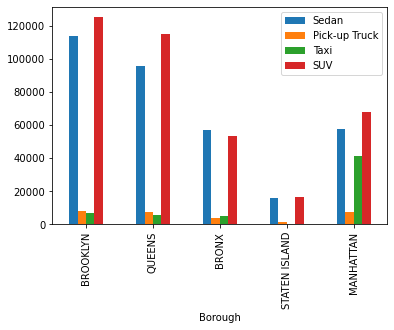

In [24]:
frames.plot(x='Borough',y=["Sedan","Pick-up Truck","Taxi","SUV"],kind ='bar')

In [25]:
airbnbData.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [26]:
avgData = airbnbData.groupby('neighbourhood_group')['price'].mean()
labels = avgData.index
labels

Index(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], dtype='object', name='neighbourhood_group')

And let's plot out the average price of airbnb rent price in each borough.

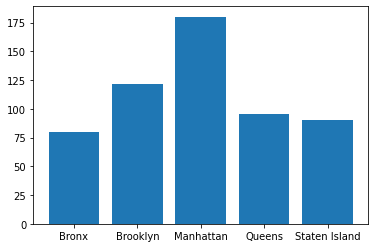

In [27]:
plt.bar(labels, avgData)
plt.show()

# Explore New York neighborhood data
Download and open json file from https://cocl.us/new_york_dataset

In [28]:
with open('data/nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [29]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Load json data into Pandas DataFrame

In [30]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough.upper(),
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods

C:\Users\amper\AppData\Local\Temp/ipykernel_4848/1406658274.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighborhoods = neighborhoods.append({'Borough': borough.upper(),
C:\Users\amper\AppData\Local\Temp/ipykernel_4848/1406658274.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighborhoods = neighborhoods.append({'Borough': borough.upper(),
C:\Users\amper\AppData\Local\Temp/ipykernel_4848/1406658274.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  neighborhoods = neighborhoods.append({'Borough': borough.upper(),
C:\Users\amper\AppData\Local\Temp/ipykernel_4848/1406658274.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,Borough,Neighborhood,Latitude,Longitude
0,BRONX,Wakefield,40.894705,-73.847201
1,BRONX,Co-op City,40.874294,-73.829939
2,BRONX,Eastchester,40.887556,-73.827806
3,BRONX,Fieldston,40.895437,-73.905643
4,BRONX,Riverdale,40.890834,-73.912585
...,...,...,...,...
301,MANHATTAN,Hudson Yards,40.756658,-74.000111
302,QUEENS,Hammels,40.587338,-73.80553
303,QUEENS,Bayswater,40.611322,-73.765968
304,QUEENS,Queensbridge,40.756091,-73.945631


Define a function that calculate the distance between vehicle collision and neighborhoods

In [31]:
def vehicle_collision_neighborhood(location: tuple, borough: str) ->str:
    bor = neighborhoods.loc[neighborhoods.Borough == borough, ['Borough', 'Neighborhood', 'Latitude', 'Longitude']]
    bor['Coords'] = bor[['Latitude', 'Longitude']].apply(tuple, axis=1)
    for index, row in bor.iterrows():
        bor.loc[index, 'Distance'] = geodesic(location, bor.loc[index, 'Coords']).km
    min_index = bor['Distance'].idxmin()
    return bor.loc[min_index, 'Neighborhood']

In [32]:
vehicle_collision_neighborhood((40.895437, -73.905643), 'BRONX')

'Fieldston'

## Get the neighborhood for crime

In [33]:
crimeData.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
3,189714430,11/07/2018,117.0,RECKLESS ENDANGERMENT 1,126.0,MISCELLANEOUS PENAL LAW,PL 1202500,F,M,26.0,0.0,45-64,M,WHITE,993685.0,233346.0,40.807160,-73.965920,POINT (-73.96591978699998 40.80715993100006)
5,190017529,11/15/2018,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200502,F,B,47.0,0.0,45-64,M,BLACK,1026486.0,262591.0,40.887333,-73.847250,POINT (-73.84725001299995 40.88733281800006)
10,189678705,11/07/2018,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,M,B,52.0,0.0,25-44,M,BLACK,1017542.0,255919.0,40.869059,-73.879630,POINT (-73.87963014799993 40.86905853200005)
14,189068425,10/22/2018,105.0,STRANGULATION 1ST,106.0,FELONY ASSAULT,PL 1211200,F,K,94.0,0.0,45-64,M,BLACK,995886.0,200705.0,40.717566,-73.958026,POINT (-73.95802570099994 40.71756616100004)
15,65864442,09/17/2009,164.0,SODOMY 3,116.0,SEX CRIMES,PL 1304002,F,S,122.0,0.0,25-44,M,BLACK HISPANIC,954943.0,148360.0,40.573850,-74.105496,POINT (-74.10549615599997 40.573849649000074)


In [34]:
print(crimeData['ARREST_BORO'].unique())

['M' 'B' 'K' 'S' 'Q']


In [35]:
print(neighborhoods['Borough'].unique())

['BRONX' 'MANHATTAN' 'BROOKLYN' 'QUEENS' 'STATEN ISLAND']


"BORO_NM " represents the borough where suspects were arrested, which may differ from the borough where crime happened.

In [36]:
def crime_neighborhood(location: tuple,borough: str) ->str:
    bor = neighborhoods.loc[neighborhoods.Borough == borough, ['Borough', 'Neighborhood', 'Latitude', 'Longitude']]
    bor['Coords'] = bor[['Latitude', 'Longitude']].apply(tuple, axis=1)
    for index, row in bor.iterrows():
        bor.loc[index, 'Distance'] = geodesic(location, bor.loc[index, 'Coords']).km
    min_index = bor['Distance'].idxmin()
    return bor.loc[min_index, 'Neighborhood']

In [37]:
def getNameforBorough(letter:str)->str:
    if letter == 'M':
        borough= 'MANHATTAN'
    elif letter =='B':
        borough= 'BRONX'
    elif letter == 'K':
        borough= 'BROOKLYN'
    elif letter == 'S':
        borough= 'STATEN ISLAND'
    else:
        borough = 'QUEENS'
    return borough

In [38]:
neighborhoods.loc[neighborhoods['Neighborhood'] == 'Morningside Heights']

,Borough,Neighborhood,Latitude,Longitude
125,MANHATTAN,Morningside Heights,40.808,-73.963896


In [39]:
import time
start_time = time.time()
for index, row in crimeData.iterrows():
    location = (row[16],row[17])
    borough = getNameforBorough(row[8])
    nbh = crime_neighborhood(location,borough)
    crimeData.loc[index,'neighborhoods'] =nbh
print("--- %s seconds ---" % (time.time() - start_time))

--- 98.897869348526 seconds ---


In [40]:
print(crimeData.head)

<bound method NDFrame.head of       ARREST_KEY ARREST_DATE  PD_CD                           PD_DESC  KY_CD  \
3      189714430  11/07/2018  117.0           RECKLESS ENDANGERMENT 1  126.0   
5      190017529  11/15/2018  109.0          ASSAULT 2,1,UNCLASSIFIED  106.0   
10     189678705  11/07/2018  175.0                  SEXUAL ABUSE 3,2  233.0   
14     189068425  10/22/2018  105.0                 STRANGULATION 1ST  106.0   
15      65864442  09/17/2009  164.0                          SODOMY 3  116.0   
...          ...         ...    ...                               ...    ...   
6397   189129199  10/23/2018  750.0                  RESISTING ARREST  359.0   
6398   189903488  11/12/2018  269.0    MISCHIEF,CRIMINAL,    UNCL 2ND  121.0   
6399   189435279  10/31/2018  904.0       INTOXICATED DRIVING,ALCOHOL  119.0   
6400   189557178  11/04/2018  567.0       MARIJUANA, POSSESSION 4 & 5  235.0   
6401   189404501  10/31/2018  922.0  TRAFFIC,UNCLASSIFIED MISDEMEANOR  348.0   

         